In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import tifffile
import pre_process_mm as pre
import mm3_adapted_cell_segmentation as mm3seg
import mm3_adapted_cell_tracking as mm3track
import plot_cells
import growth_curves
from skimage.draw import polygon
from matplotlib.collections import LineCollection
from skimage.measure import find_contours
from skimage import measure
from skimage.measure import regionprops, label
from skimage.io import imread
from scipy.optimize import curve_fit
from scipy.spatial.distance import euclidean
import networkx as nx

In [2]:
def plot_growth_analysis(all_cells_pd, time_col, length_col, folder, fov_id, peak_id,
                         prominence=0.3, distance=3, window_size=3):

    """Analyzes and plots cell growth data with exponential fits for detected phases."""

    cell_df = all_cells_pd.copy()

    growth_phases = growth_curves.detect_growth_phases(cell_df, time_col, length_col, prominence, distance, window_size)

    cell_df = cell_df.assign(y_fit=np.nan, residuals=np.nan, r_squared=np.nan, growth_phase=None, growth_rate_constant=np.nan, doubling_time = np.nan)

    plt.figure(figsize=(10, 6))
    growth_curves._plot_raw_data(cell_df, time_col, length_col, None)

    if not growth_phases:
        plt.title("Cell Data (No Growth Phases Detected)")
        print("No growth phases detected.")
    else:
        for i, (start, end) in enumerate(growth_phases):
            cell_df = growth_curves._process_growth_phase(cell_df, i + 1, start, end, time_col, length_col)

        plt.title(f'Cell Growth Analysis {folder} FOV {fov_id} trench {peak_id}')

    plt.xlabel('Time (min)')
    plt.ylabel('Cell Length (pxls)')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

    return cell_df

In [3]:
def _add_time_frame_df(full_region_df, labeled_stack_px_width, mask_kymograph_px_width, x_centroid_col = 'centroid-1'):
    time_frame_pixel_dict = _make_time_frame_pixel_dict(labeled_stack_px_width, mask_kymograph_px_width)
    full_region_df['time_frame'] = full_region_df['centroid-1'].apply(_map_pixel_to_index, range_dict=time_frame_pixel_dict)
    
def _make_time_frame_pixel_dict(labeled_stack_px_width, mask_kymograph_px_width):
    enumerated_x_increments_dict = {index: value for index, value in enumerate(list(range(labeled_stack_px_width, mask_kymograph_px_width+1, labeled_stack_px_width)))}
    time_frame_pixel_dict = {}
    for time_frame, x_limit in enumerated_x_increments_dict.items():
        time_frame_pixel_dict[time_frame] = (x_limit-labeled_stack_px_width, x_limit-1)
    return time_frame_pixel_dict
def _map_pixel_to_index(pixel, range_dict):
    for index, (min_val, max_val) in range_dict.items():
        if min_val <= pixel <= max_val:
            return index
    return None

In [4]:
def plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, fig_dir, track_id_col='track_id'):
    fig, ax = plt.subplots(2,1, figsize=(40, 10))

    # Get kymograph shape once for both calls
    kymograph_shape = phase_kymograph.shape

    ax[0].imshow(phase_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[0], full_region_df, kymograph_shape, y_coord_col = 'centroid-0', x_coord_col = 'centroid-1', lineage_col = track_id_col)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    ax[1].imshow(fluor_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[1], full_region_df, kymograph_shape, y_coord_col = 'centroid-0', x_coord_col = 'centroid-1', lineage_col = track_id_col)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_title(f'Fluorescence Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    plt.xlabel("Time frames")
    plt.tight_layout()
    plt.savefig(fig_dir)
    plt.close(fig)

def _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid-0', x_coord_col = 'centroid-1', lineage_col = None):
    default_cell_contour_color = '#AA5486'
    default_centroid_color = '#FC8F54'

    # Prepare data for LineCollection for contours
    all_contours_segments = []
    all_contour_colors = []
    
    # Prepare data for centroids
    centroid_x_coords = []
    centroid_y_coords = []
    centroid_colors = []

    if lineage_col:
        unique_track_ids = full_region_df[lineage_col].dropna().unique()
        colors_cmap = plt.get_cmap('tab20', len(unique_track_ids))
        track_colors = {track_id: colors_cmap(i) for i, track_id in enumerate(unique_track_ids)}

    for index, region_props in full_region_df.iterrows():
        # 'coords' are assumed to be (row, col) pixels within the mask
        cell_pixel_coords = np.array(region_props['coords']) # e.g., [[r1,c1], [r2,c2], ...]

        # Calculate bounding box for the current cell's mask
        min_row, min_col = np.min(cell_pixel_coords, axis=0)
        max_row, max_col = np.max(cell_pixel_coords, axis=0)

        # Create a small temporary mask for the current cell
        # Add a small buffer to ensure contours are fully captured if they go to edge
        buffer = 1
        bbox_min_row = max(0, min_row - buffer)
        bbox_min_col = max(0, min_col - buffer)
        bbox_max_row = min(kymograph_shape[0], max_row + buffer)
        bbox_max_col = min(kymograph_shape[1], max_col + buffer)

        temp_mask_shape = (bbox_max_row - bbox_min_row + 1, bbox_max_col - bbox_min_col + 1)
        temp_mask = np.zeros(temp_mask_shape, dtype=np.uint8)

        # Map cell_pixel_coords to relative coordinates within temp_mask
        relative_rows = cell_pixel_coords[:, 0] - bbox_min_row
        relative_cols = cell_pixel_coords[:, 1] - bbox_min_col
        
        # Populate the temporary mask
        temp_mask[relative_rows, relative_cols] = 1

        # Find contours on this small temporary mask
        # level=0.5 means it finds contours at the boundary between 0 and 1
        # fully_connected='high' means it considers 8-connectivity for background, 4-connectivity for foreground
        contours = find_contours(temp_mask, level=0.5, fully_connected='high')

        if not contours:
            continue # Skip if no contour found (e.g., single pixel or degenerate mask)

        # `find_contours` returns (row, col) coordinates for the contour.
        # We need to convert them back to global kymograph coordinates.
        # And convert to (x, y) for plotting (col, row)
        global_contours = []
        for contour in contours:
            # Shift back to global coordinates and swap for (x, y) plotting
            global_contour_x = contour[:, 1] + bbox_min_col
            global_contour_y = contour[:, 0] + bbox_min_row
            global_contours.append(np.vstack([global_contour_x, global_contour_y]).T)

        y_coord = region_props[y_coord_col]
        x_coord = region_props[x_coord_col]
        
        # Determine color for the current cell
        if lineage_col and region_props[lineage_col] in track_colors:
            current_color = track_colors[region_props[lineage_col]]
        else:
            current_color = default_cell_contour_color

        # Add all contours for this cell to the main list, with the determined color
        for contour_segment in global_contours:
            all_contours_segments.append(contour_segment)
            all_contour_colors.append(current_color)
            
        # Add centroid data
        centroid_x_coords.append(x_coord)
        centroid_y_coords.append(y_coord)
        centroid_colors.append(current_color if lineage_col else default_centroid_color)


    # Plot all cell contours at once using LineCollection
    if all_contours_segments: # Only plot if there are segments to draw
        line_collection = LineCollection(all_contours_segments, colors=all_contour_colors, linewidths=0.5)
        ax.add_collection(line_collection)

    # Plot all centroids at once using scatter
    if centroid_x_coords: # Only plot if there are centroids
        ax.scatter(centroid_x_coords, centroid_y_coords, color=centroid_colors, s=5, zorder=2)

In [5]:
def _create_kymograph(phase_stack, start, end, fov_id, peak_id, output_dir):
    """Creates and saves a kymograph."""
    kymographs_gray = []
    for i in range(start, end):
        phase = phase_stack[i]
        if phase.ndim == 3:
            kymographs_gray.append(np.mean(phase, axis=2))
        else:
            kymographs_gray.append(phase)

    combined_kymograph = np.concatenate(kymographs_gray, axis=1)
    lin_filename = f'{fov_id}_{peak_id}.tif'
    lin_filepath = os.path.join(output_dir, lin_filename)  # Use output_dir
    tifffile.imwrite(lin_filepath, combined_kymograph)
    return combined_kymograph

In [6]:
def link_cells_graph_based(df, max_distance_y=5, max_diff_area_ratio=0.5, area_weight_factor=0.1,  preference_upward_shift=0.5):
    """
    Links cells across multiple frames using a graph-based approach.

    Args:
        df (pd.DataFrame): DataFrame with region properties, including
                           'frame', 'label', 'centroid', 'area'.
        max_distance_centroid (float): Maximum allowed Euclidean distance
                                       between centroids in consecutive frames
                                       to consider a potential link.
        max_diff_area_ratio (float): Maximum allowed ratio of the absolute
                                     difference in area to the average area
                                     to consider a potential link.

    Returns:
        pd.DataFrame: DataFrame with an added 'track_id' column indicating the
                      linked cell track ID.
    """
    if 'time_frame' not in df.columns:
        raise ValueError("DataFrame must have a 'frame' column.")

    unique_frames = sorted(df['time_frame'].unique())
    graph = nx.DiGraph()
    node_id_counter = 0
    node_map = {}  # (frame, label) -> node_id

    # Add nodes for each detection
    for frame in unique_frames:
        frame_df = df[df['time_frame'] == frame].copy()
        for index, row in frame_df.iterrows():
            node_id = node_id_counter
            graph.add_node(node_id, frame=row['time_frame'], label=row['label'],
                           centroid=row['centroid-0'], area=row['area'])
            node_map[(row['time_frame'], row['label'])] = node_id
            node_id_counter += 1

    # Add edges between potential links in consecutive frames
    for i in range(len(unique_frames) - 1):
        current_frame = unique_frames[i]
        next_frame = unique_frames[i + 1]

        current_frame_df = df[df['time_frame'] == current_frame]
        next_frame_df = df[df['time_frame'] == next_frame]

        for _, current_row in current_frame_df.iterrows():
            current_centroid_y = current_row['centroid-0']
            current_area = current_row['area']
            current_node_id = node_map[(current_row['time_frame'], current_row['label'])]

            for _, next_row in next_frame_df.iterrows():
                next_centroid_y = next_row['centroid-0']
                next_area = next_row['area']
                next_node_id = node_map[(next_row['time_frame'], next_row['label'])]

                y_distance = abs(current_centroid_y - next_centroid_y)
                avg_area = (current_area + next_area) / 2
                diff_area_ratio = abs(current_area - next_area) / avg_area if avg_area > 0 else 0

                if y_distance <= max_distance_y and diff_area_ratio <= max_diff_area_ratio:
                    # Add an edge with a weight representing the "cost" of the link
                    # Lower weight means a more likely link
                    weight = y_distance + area_weight_factor * diff_area_ratio
                    # Apply preference for upward shift (smaller y in next frame)
                    if next_centroid_y <= current_centroid_y:
                        weight *= (1 - preference_upward_shift)
                    graph.add_edge(current_node_id, next_node_id, weight=weight)

    # Find tracks as paths through the graph
    tracks = []
    visited_nodes = set()

    for node_id in graph.nodes():
        if node_id not in visited_nodes and not list(graph.predecessors(node_id)):
            # Start a new track from a node with no predecessors
            current_track = [node_id]
            current_node = node_id
            visited_nodes.add(node_id)

            while True:
                successors = list(graph.successors(current_node))
                if not successors:
                    break

                # For simplicity, choose the successor with the minimum weight edge
                best_successor = None
                min_weight = float('inf')
                for successor in successors:
                    weight = graph.get_edge_data(current_node, successor)['weight']
                    if weight < min_weight:
                        min_weight = weight
                        best_successor = successor

                if best_successor is not None:
                    current_track.append(best_successor)
                    visited_nodes.add(best_successor)
                    current_node = best_successor
                else:
                    break
            if current_track:
                tracks.append(current_track)

    # Assign track IDs back to the DataFrame
    df['track_id'] = np.nan
    track_id_counter = 1
    for track in tracks:
        for node_id in track:
            node_info = graph.nodes[node_id]
            frame = node_info['frame']
            label = node_info['label']
            df.loc[(df['time_frame'] == frame) & (df['label'] == label), 'track_id'] = track_id_counter
        track_id_counter += 1

    return df

# select cells starting at t= 28 for fov 005
lineage_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['445', '900', '1128', '1277', '1887',  '2115', '2344', '2421', '2497']
         }
           }
test_lineage_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['445']}}

seg_FOV_dict = {'DUMM_giTG66_Glucose_012325':
                {
                    #seems like I only did subtraction for FOV 003
                    '003':['250', '275','453', '479']
                }
                
           }
seg_FOV_dict = {'DUMM_giTG059_noKan_Glucose_031125':
    {

        '004':['756', '832', '72', '1820', '985', '1061', '2276']
    }
    
}
time_range_dict = {'DUMM_giTG059_noKan_Glucose_031125':
                   {'004':{'756':{'start':0, 
                                   'end':96}, 
                           '832':{'start':29, 
                                   'end':178}, 
                            '72':{'start':14, 
                                   'end':81}, 
                            '1820':{'start':0, 
                                   'end':150}, 
                            '985':{'start':18, 
                                   'end':82}, 
                            '1061':{'start':14, 
                                   'end':77}, 
                            '2276':{'start':21, 
                                   'end':77}
                          }
                   }
                  }
seg_FOV_dict = {'DUMM_giTG064_Glucose_022625':
                {

                    '001':['114', '189', '415', '867', '943', '1697', '2376'],
                
                    '015':['796']
                }
                
           }

time_range_dict = {'DUMM_giTG064_Glucose_022625':
                   {'001':{'114':{'start':39, 
                                   'end':176}, 
                           '189':{'start':39, 
                                   'end':125}, 
                            '415':{'start':39, 
                                   'end':176}, 
                            '867':{'start':39, 
                                   'end':170}, 
                            '943':{'start':39, 
                                   'end':176}, 
                            '1697':{'start':39, 
                                   'end':139}, 
                            '2376':{'start':39, 
                                   'end':139}
                          },
                    '015':{'796':{'start':0, 
                                   'end':179}
                          }
                    }
                   }

In [42]:
seg_FOV_dict = {'DUMM_giTG69_Glucose_013025':
                {

                    '007':['295','371','521','597','1124']
                }
                
           }

In [43]:
time_range_dict = {'DUMM_giTG69_Glucose_013025':
                   {'007':{'295':{'start':33, 
                                   'end':160}, 
                           '371':{'start':33, 
                                   'end':179}, 
                            '521':{'start':80, 
                                   'end':179}, 
                            '597':{'start':80, 
                                   'end':179}, 
                            '1124':{'start':71, 
                                   'end':179}
                          }
                    }
                   }

In [44]:
phase_channel = '0'
fluor_channel = '1'
for folder, fov_dict in seg_FOV_dict.items():
    all_cells_pd = pd.DataFrame()
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            path_to_phase_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            path_to_fluor_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'
            path_to_labeled_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            phase_stack = tifffile.imread(path_to_phase_stack)
            labeled_stack = tifffile.imread(path_to_labeled_stack)
            fluor_stack = tifffile.imread(path_to_fluor_stack)
            start = time_range_dict[folder][fov_id][peak_id]['start']
            end = time_range_dict[folder][fov_id][peak_id]['end']
            phase_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted'
            phase_kymograph = _create_kymograph(phase_stack, start, end, fov_id, peak_id, phase_output_dir)
            mask_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mask'
            os.makedirs(mask_output_dir, exist_ok=True)
            mask_kymograph = _create_kymograph(labeled_stack, start, end, fov_id, peak_id, mask_output_dir)
            fluor_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor'
            os.makedirs(fluor_output_dir, exist_ok=True)
            fluor_kymograph = _create_kymograph(fluor_stack, start, end, fov_id, peak_id, fluor_output_dir)
            labeled_kymograph_mask = label(mask_kymograph)
            props = measure.regionprops_table(labeled_kymograph_mask, phase_kymograph,
                          properties=['label', 'area', 'coords', 'centroid', 'axis_major_length', 'axis_minor_length',
                                      'intensity_mean', 'intensity_max', 'intensity_min'])
            props_fluor = measure.regionprops_table(labeled_kymograph_mask, fluor_kymograph,
                          properties=['label',
                                      'intensity_mean', 'intensity_max', 'intensity_min'])
            region_phase_df = pd.DataFrame(props)
            region_fluor_df = pd.DataFrame(props_fluor)
            full_region_df = region_phase_df.merge(region_fluor_df, how = 'inner', on = 'label', suffixes = ('_phase', '_fluor'))
            labeled_stack_px_width = labeled_stack.shape[-1]
            mask_kymograph_px_width = mask_kymograph.shape[-1]
            _add_time_frame_df(full_region_df, labeled_stack_px_width, mask_kymograph_px_width, x_centroid_col = 'centroid-1')
            full_region_df['experiment_name']= folder
            full_region_df['FOV']= fov_id
            full_region_df['trench_id']= peak_id
            cells_tracked_df = link_cells_graph_based(full_region_df, max_distance_y=5, max_diff_area_ratio=0.5, area_weight_factor=0.1,  preference_upward_shift=0.5)
            fig_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/cells_detected_{folder}_FOV_{fov_id}_peak_{peak_id}.png'
            plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    cells_tracked_df, 
                                    folder, fov_id, peak_id, 
                                    fig_dir, 
                                    track_id_col='track_id')
            if all_cells_pd.empty:
                all_cells_pd = cells_tracked_df
            else:
                all_cells_pd = pd.concat([all_cells_pd, cells_tracked_df], ignore_index=True)
    all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_data_{folder}.pkl'
    all_cells_pd.to_pickle(all_cells_filename)

In [54]:
all_cells_pd

,label,area,coords,centroid-0,centroid-1,axis_major_length,axis_minor_length,intensity_mean_phase,intensity_max_phase,intensity_min_phase,intensity_mean_fluor,intensity_max_fluor,intensity_min_fluor,time_frame,experiment_name,FOV,trench_id,track_id
0,1,240.0,"[[5, 230], [6, 230], [6, 231], [7, 229], [7, 2...",22.525000,227.562500,35.763735,8.859051,12210.533333,18111.0,7754.0,5.891667,25.0,0.0,11,DUMM_giTG69_Glucose_013025,007,295,83.0
1,2,195.0,"[[7, 190], [8, 189], [8, 190], [9, 188], [9, 1...",21.107692,187.466667,29.041259,8.690217,11896.189744,17331.0,7689.0,7.071795,25.0,0.0,9,DUMM_giTG69_Glucose_013025,007,295,68.0
2,3,149.0,"[[7, 1008], [8, 1007], [8, 1008], [8, 1009], [...",18.228188,1008.080537,22.307081,8.578548,12716.302013,19960.0,8554.0,5.557047,19.0,0.0,50,DUMM_giTG69_Glucose_013025,007,295,260.0
3,4,227.0,"[[8, 88], [9, 85], [9, 86], [9, 87], [9, 88], ...",21.731278,87.224670,29.701161,9.999187,12464.008811,19354.0,7847.0,6.837004,27.0,0.0,4,DUMM_giTG69_Glucose_013025,007,295,32.0
4,5,249.0,"[[8, 128], [8, 129], [8, 130], [9, 126], [9, 1...",23.112450,127.313253,34.748980,9.419553,12290.132530,17753.0,7836.0,9.405622,25.0,0.0,6,DUMM_giTG69_Glucose_013025,007,295,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,743,113.0,"[[336, 1870], [336, 1871], [336, 1872], [336, ...",344.221239,1870.929204,18.228233,7.984557,9631.778761,11595.0,7625.0,10.035398,28.0,0.0,93,DUMM_giTG69_Glucose_013025,007,1124,504.0
2915,744,101.0,"[[337, 1050], [337, 1051], [337, 1052], [337, ...",344.049505,1050.900990,15.684095,8.300735,9903.772277,12091.0,7563.0,11.673267,26.0,0.0,52,DUMM_giTG69_Glucose_013025,007,1124,282.0
2916,745,114.0,"[[337, 1650], [337, 1651], [337, 1652], [338, ...",345.017544,1650.429825,17.140526,8.547865,10364.184211,12793.0,8066.0,13.885965,25.0,1.0,82,DUMM_giTG69_Glucose_013025,007,1124,427.0
2917,746,121.0,"[[337, 2030], [337, 2031], [337, 2032], [338, ...",345.504132,2030.842975,18.179678,8.550118,9481.371901,11860.0,7201.0,12.380165,23.0,0.0,101,DUMM_giTG69_Glucose_013025,007,1124,548.0


In [49]:
bottom_cell_mask = all_cells_pd.groupby(['time_frame', 'FOV', 'trench_id'])['centroid-0'].idxmax()
bottom_cell_df = all_cells_pd.loc[bottom_cell_mask]
# only keep bottom cell at the bottom of the trench
low_bottom_cell_df = bottom_cell_df[bottom_cell_df['centroid-0'] > 120]

In [50]:
low_bottom_cell_df['time_min'] = low_bottom_cell_df['time_frame']*5 

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_36750/1884784248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_bottom_cell_df['time_min'] = low_bottom_cell_df['time_frame']*5


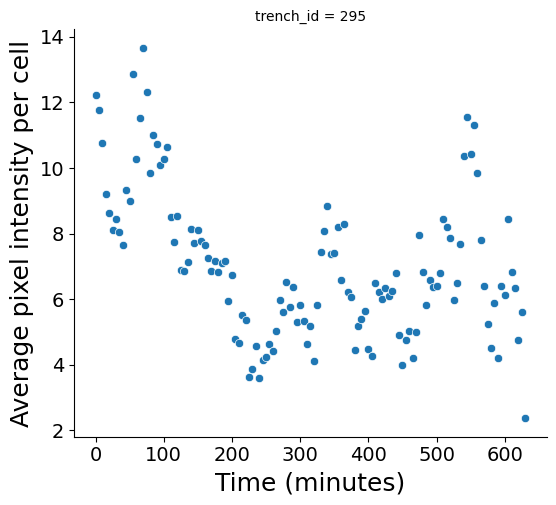

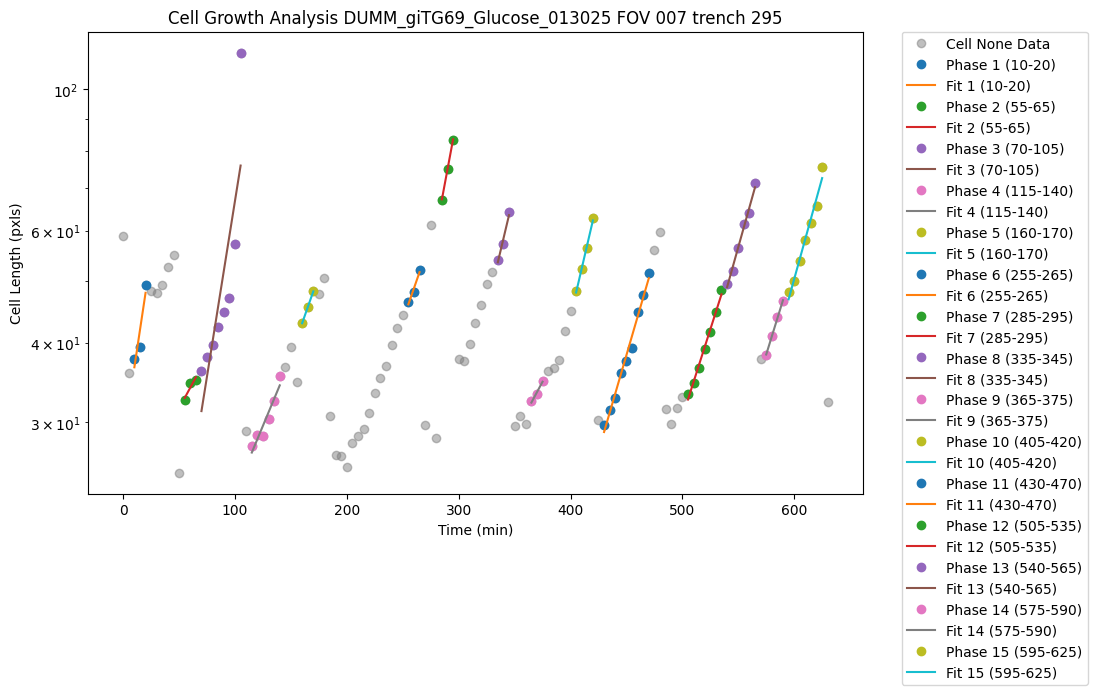

Skipping Phase 4 (155-165): Fit failed or poor R-squared (-0.03).


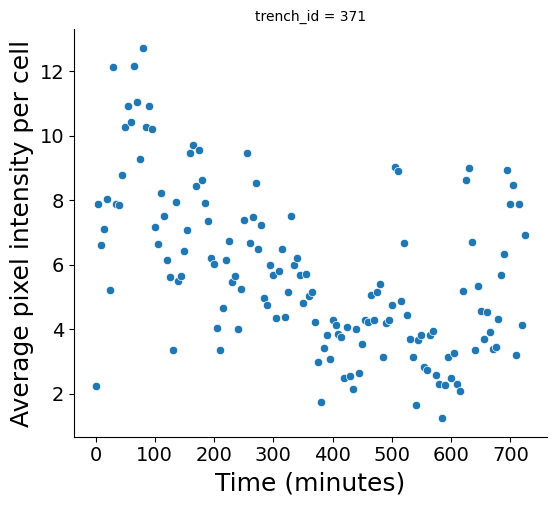

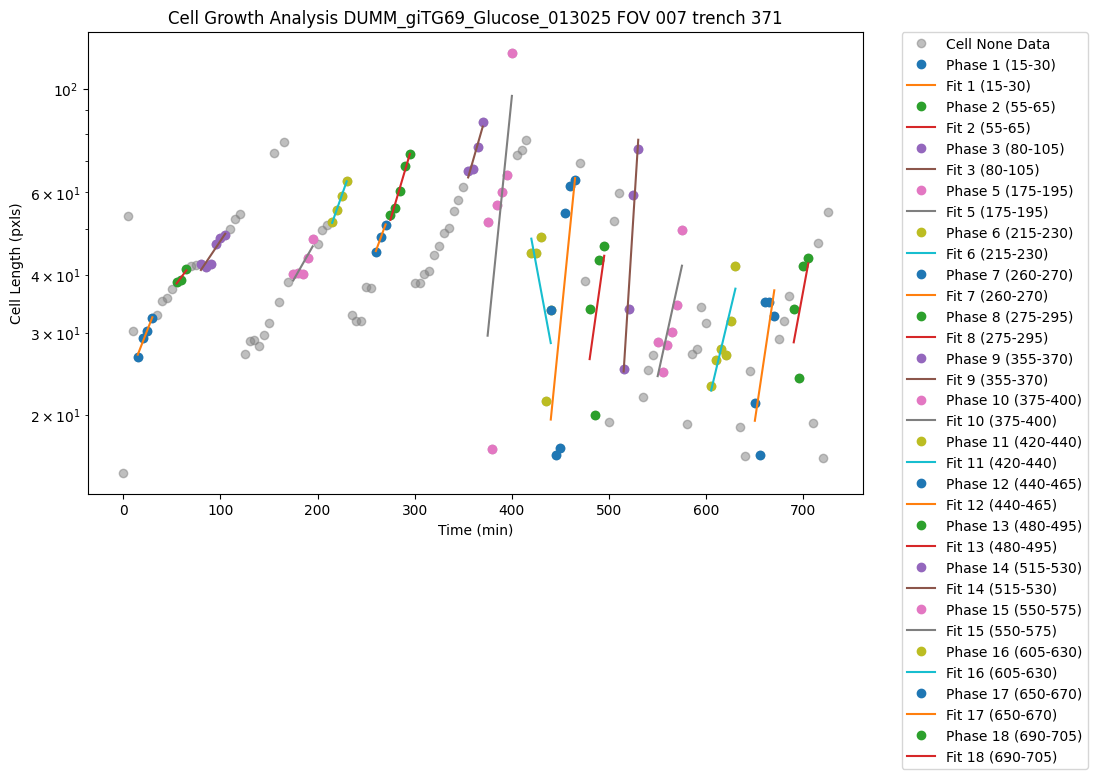

Skipping Phase 4 (145-170): Fit failed or poor R-squared (0.09).


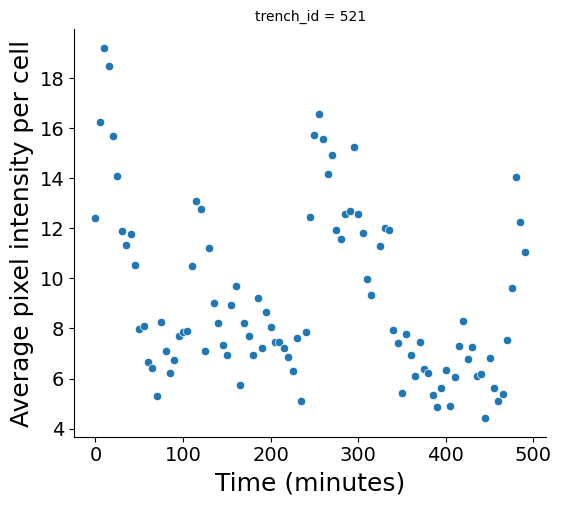

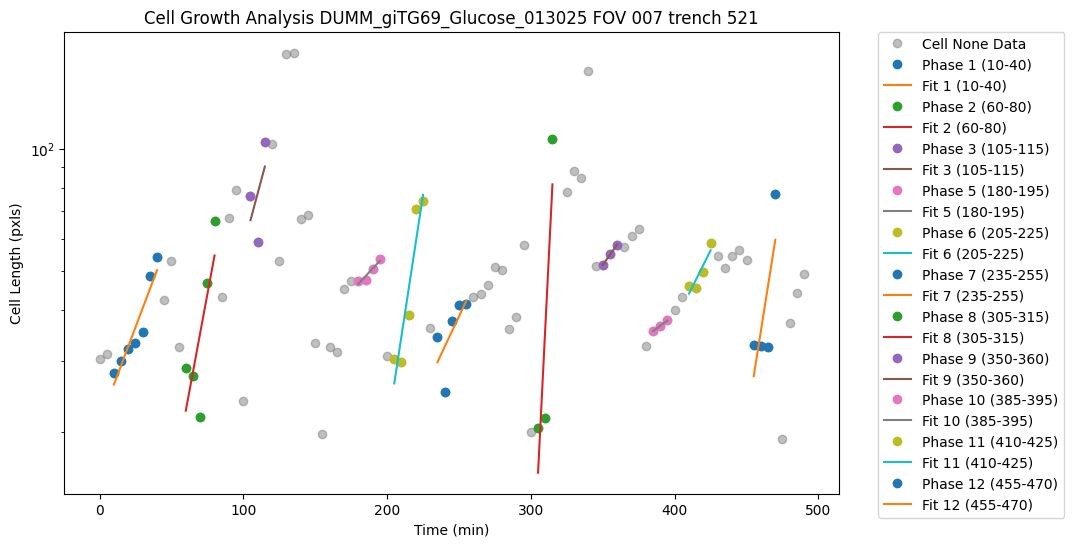

Skipping Phase 7 (220-230): Fit failed or poor R-squared (0.13).
Skipping Phase 13 (435-445): Fit failed or poor R-squared (0.04).


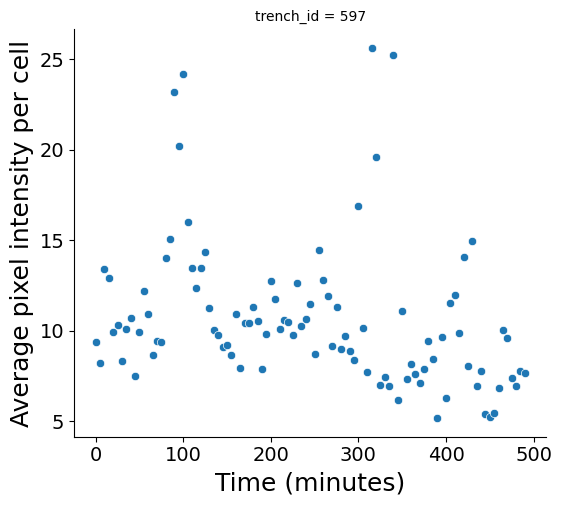

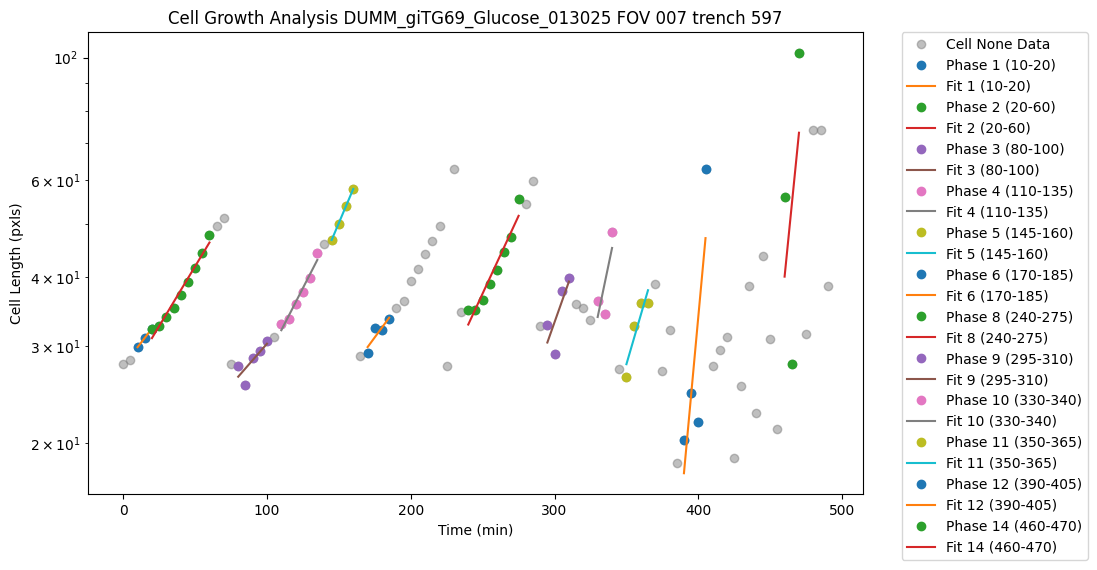

Skipping Phase 7 (250-265): Fit failed or poor R-squared (0.16).
Skipping Phase 9 (320-340): Fit failed or poor R-squared (0.16).


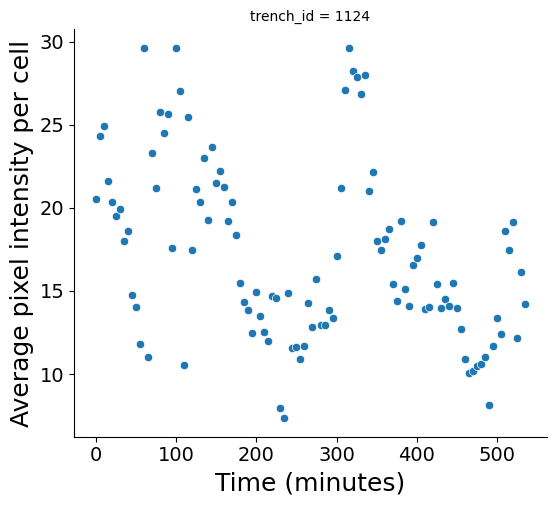

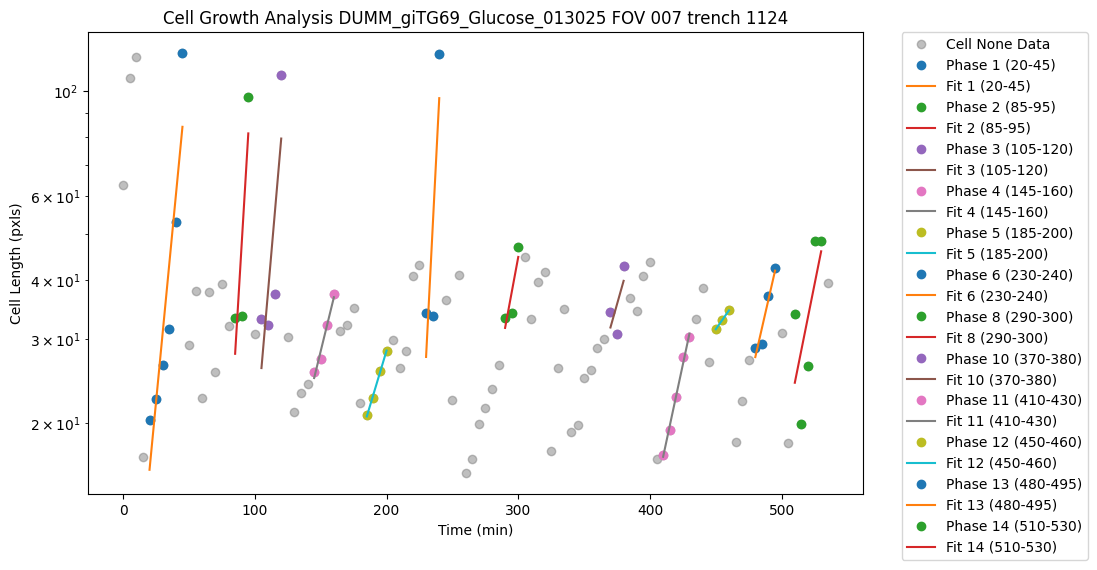

In [51]:
for folder, fov_dict in seg_FOV_dict.items():
    growth_all_cells_pd = pd.DataFrame()
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            cells_tracked_df = low_bottom_cell_df[(low_bottom_cell_df['experiment_name']== folder) 
                                                    & (low_bottom_cell_df['FOV']== fov_id)
                                                    & (low_bottom_cell_df['trench_id']== peak_id)]
            #eliminate border detection artifacts
            filtered_cells = cells_tracked_df[cells_tracked_df['axis_major_length'] <600]
            lin_filename = f'{fov_id}_{peak_id}.tif'
            phase_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted'
            phase_filepath = os.path.join(phase_output_dir, lin_filename)
            phase_kymograph = tifffile.imread(phase_filepath)
            fluor_output_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor'
            fluor_filepath = os.path.join(fluor_output_dir, lin_filename)
            fluor_kymograph = tifffile.imread(fluor_filepath)
            fig_dir = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/cells_detected_{folder}_FOV_{fov_id}_peak_{peak_id}_bottom_cell.png'
            plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    filtered_cells, 
                                    folder, fov_id, peak_id, 
                                    fig_dir, 
                                    track_id_col=None)
            g = sns.relplot(data=filtered_cells, x= 'time_min', y= 'intensity_mean_fluor',
             col = 'trench_id',col_wrap = 5)
            # Increase x-axis label font size
            g.set_axis_labels(x_var='Time (minutes)', y_var= 'Average pixel intensity per cell', fontsize=18)
            for ax in g.axes.flat:
                ax.tick_params(axis='x', labelsize=14)
                ax.tick_params(axis='y', labelsize=14)
            
            sns.despine();

            growth_det = plot_growth_analysis(filtered_cells,'time_min', 'axis_major_length',
                                              folder, fov_id, peak_id, prominence=0.1, distance=5, window_size=3);
            if growth_all_cells_pd.empty:
                growth_all_cells_pd = growth_det
            else:
                growth_all_cells_pd = pd.concat([growth_all_cells_pd, growth_det], ignore_index=True)
    growth_all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/growth_all_cell_data_{folder}.pkl'
    growth_all_cells_pd.to_pickle(growth_all_cells_filename)

# eliminate trenches with poor detection
filtered_growth = growth_all_cells_pd[~growth_all_cells_pd['trench_id'].isin(['1128', '1277', '1887', '2115'])]

cells_growth_rates_pd = filtered_growth[['experiment_name', 'FOV', 'trench_id', 'growth_phase', 'growth_rate_constant', 'doubling_time']].drop_duplicates()
cleaned_growth_cells = cells_growth_rates_pd[(cells_growth_rates_pd['doubling_time'] > 0) & (cells_growth_rates_pd['doubling_time'] < 100)]

In [52]:
cells_growth_rates_pd = growth_all_cells_pd[['experiment_name', 'FOV', 'trench_id', 'growth_phase', 'growth_rate_constant', 'doubling_time']].drop_duplicates()
cleaned_growth_cells = cells_growth_rates_pd[(cells_growth_rates_pd['doubling_time'] > 0) & (cells_growth_rates_pd['doubling_time'] < 100)]

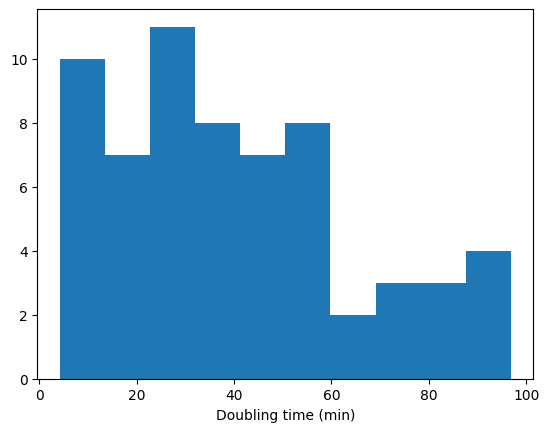

In [53]:
plt.hist(cleaned_growth_cells['doubling_time'].dropna(), bins=10);
plt.xlabel('Doubling time (min)');

In [44]:
growth_all_cells_pd

,label,area,coords,centroid-0,centroid-1,axis_major_length,axis_minor_length,intensity_mean_phase,intensity_max_phase,intensity_min_phase,...,FOV,trench_id,track_id,time_min,y_fit,residuals,r_squared,growth_phase,growth_rate_constant,doubling_time
0,762,59.0,"[[103, 9], [103, 10], [104, 8], [104, 9], [104...",111.542373,9.711864,20.567692,3.784815,1246.474576,1640.0,880.0,...,003,250,4.0,0.0,NaN,NaN,NaN,None,NaN,NaN
1,753,63.0,"[[102, 29], [102, 30], [102, 31], [103, 28], [...",110.444444,29.793651,21.316840,3.924454,1163.603175,1528.0,843.0,...,003,250,4.0,5.0,NaN,NaN,NaN,None,NaN,NaN
2,754,63.0,"[[102, 50], [102, 51], [103, 49], [103, 50], [...",112.253968,49.920635,24.587023,3.571863,1168.841270,1469.0,834.0,...,003,250,4.0,10.0,NaN,NaN,NaN,None,NaN,NaN
3,755,63.0,"[[102, 69], [102, 70], [102, 71], [103, 69], [...",112.015873,70.031746,24.331970,3.256035,1238.539683,1616.0,842.0,...,003,250,4.0,15.0,NaN,NaN,NaN,None,NaN,NaN
4,713,68.0,"[[92, 89], [92, 90], [93, 89], [93, 90], [94, ...",103.573529,89.632353,24.241944,3.845115,1208.044118,1586.0,839.0,...,003,250,10.0,20.0,NaN,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,447,21.0,"[[119, 1070], [119, 1071], [120, 1070], [120, ...",123.333333,1070.571429,10.134188,2.896759,1108.904762,1609.0,729.0,...,003,479,56.0,265.0,NaN,NaN,NaN,None,NaN,NaN
434,444,26.0,"[[118, 1090], [119, 1090], [119, 1091], [120, ...",122.923077,1090.192308,10.585756,3.308729,1022.538462,1654.0,697.0,...,003,479,56.0,270.0,NaN,NaN,NaN,None,NaN,NaN
435,445,25.0,"[[118, 1110], [119, 1109], [119, 1110], [119, ...",122.320000,1110.000000,9.647881,3.200000,1072.400000,1531.0,768.0,...,003,479,56.0,275.0,NaN,NaN,NaN,None,NaN,NaN
436,446,25.0,"[[118, 1129], [118, 1130], [119, 1129], [119, ...",122.960000,1129.920000,11.212483,3.031870,1043.000000,1520.0,735.0,...,003,479,56.0,280.0,NaN,NaN,NaN,None,NaN,NaN


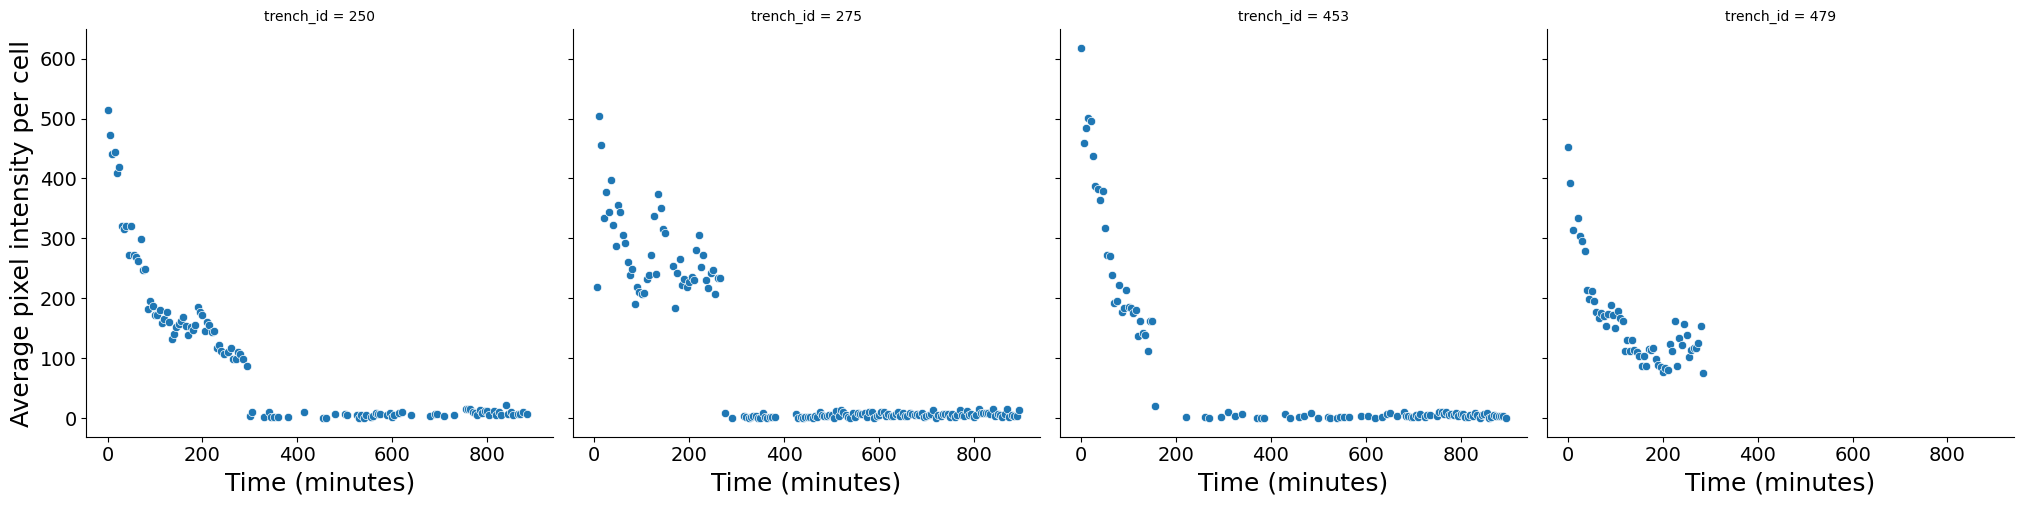

In [43]:
g = sns.relplot(data=growth_all_cells_pd, x= 'time_min', y= 'intensity_mean_fluor',
             col = 'trench_id',col_wrap = 5)
# Increase x-axis label font size
g.set_axis_labels(x_var='Time (minutes)', y_var= 'Average pixel intensity per cell', fontsize=18)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

sns.despine();

In [42]:


plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, fig_dir, track_id_col='track_id')
bottom_cell_df

,label,area,coords,centroid-0,centroid-1,axis_major_length,axis_minor_length,intensity_mean_phase,intensity_max_phase,intensity_min_phase,intensity_mean_fluor,intensity_max_fluor,intensity_min_fluor,time_frame,experiment_name,FOV,trench_id,track_id
761,762,59.0,"[[103, 9], [103, 10], [104, 8], [104, 9], [104...",111.542373,9.711864,20.567692,3.784815,1246.474576,1640.0,880.0,513.966102,851.0,100.0,0.0,DUMM_giTG66_Glucose_012325,003,250,4.0
1260,373,45.0,"[[70, 9], [71, 9], [71, 10], [72, 9], [72, 10]...",78.577778,9.088889,17.959462,3.125358,1248.955556,1554.0,977.0,286.933333,515.0,79.0,0.0,DUMM_giTG66_Glucose_012325,003,275,4.0
2130,616,29.0,"[[111, 9], [112, 9], [112, 10], [113, 9], [113...",117.965517,9.482759,15.276672,2.897003,1356.310345,1795.0,869.0,617.965517,897.0,200.0,0.0,DUMM_giTG66_Glucose_012325,003,453,4.0
2599,421,35.0,"[[112, 9], [112, 10], [113, 9], [113, 10], [11...",118.114286,9.200000,13.750238,3.549120,1321.228571,2165.0,984.0,451.914286,676.0,115.0,0.0,DUMM_giTG66_Glucose_012325,003,479,4.0
752,753,63.0,"[[102, 29], [102, 30], [102, 31], [103, 28], [...",110.444444,29.793651,21.316840,3.924454,1163.603175,1528.0,843.0,471.984127,787.0,76.0,1.0,DUMM_giTG66_Glucose_012325,003,250,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2423,245,29.0,"[[5, 3568], [5, 3569], [5, 3570], [5, 3571], [...",7.689655,3570.482759,8.493415,5.183421,484.034483,989.0,226.0,7.034483,25.0,0.0,178.0,DUMM_giTG66_Glucose_012325,003,479,113.0
354,355,44.0,"[[6, 3591], [6, 3592], [6, 3593], [6, 3594], [...",12.886364,3591.295455,19.327373,3.733667,666.113636,1117.0,423.0,13.000000,42.0,0.0,179.0,DUMM_giTG66_Glucose_012325,003,250,309.0
1514,627,15.0,"[[126, 3587], [126, 3588], [126, 3589], [126, ...",127.000000,3589.000000,5.656854,3.265986,443.600000,771.0,281.0,13.600000,26.0,0.0,179.0,DUMM_giTG66_Glucose_012325,003,275,188.0
2047,533,11.0,"[[87, 3587], [88, 3587], [88, 3588], [89, 3587...",89.454545,3587.181818,5.257030,2.793144,238.909091,313.0,193.0,0.000000,0.0,0.0,179.0,DUMM_giTG66_Glucose_012325,003,453,336.0


285